In [1]:
import sys
sys.path.append("../")
from Linearity import Neuron
import numpy as np
import scipy.stats as ss
import matplotlib
import matplotlib.pyplot as plt
from pickle import dump, load
plt.style.use('neuron')

In [2]:
def simpleaxis(axes, every=False, outward=False):
    if not isinstance(axes, (list, np.ndarray)):
        axes = np.array([axes])
    for ax in np.array(axes).flatten():
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if (outward):
            ax.spines['bottom'].set_position(('outward', 10))
            ax.spines['left'].set_position(('outward', 10))
        if every:
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_title('')

In [3]:
#fileList = glob.glob("/media/sahil/NCBS_Shares_BGStim/patch_data/**/c?/plots/*.pkl")
neuronList = []
with open("/media/sahil/NCBS_Shares_BGStim/patch_data/current_clamp_files.txt", 'r') as fp:
    fileList = fp.read().splitlines()
    for i,filename in enumerate(fileList):
        fileList[i] += "plots/" + filename.split('/')[-2] + ".pkl"
        try:
            print ("Reading ", fileList[i])
            neuronList.append(Neuron.load(fileList[i]))
        except:
            print ("Couldn't read", fileList[i])
print ("Read {} files.".format(len(fileList)))

Reading  /media/sahil/NCBS_Shares_BGStim/patch_data/150828/c2/plots/c2.pkl
Couldn't read /media/sahil/NCBS_Shares_BGStim/patch_data/150828/c2/plots/c2.pkl
Reading  /media/sahil/NCBS_Shares_BGStim/patch_data/150902/c1/plots/c1.pkl
Couldn't read /media/sahil/NCBS_Shares_BGStim/patch_data/150902/c1/plots/c1.pkl
Reading  /media/sahil/NCBS_Shares_BGStim/patch_data/150902/c2/plots/c2.pkl
Couldn't read /media/sahil/NCBS_Shares_BGStim/patch_data/150902/c2/plots/c2.pkl
Reading  /media/sahil/NCBS_Shares_BGStim/patch_data/150904/c1/plots/c1.pkl
Couldn't read /media/sahil/NCBS_Shares_BGStim/patch_data/150904/c1/plots/c1.pkl
Reading  /media/sahil/NCBS_Shares_BGStim/patch_data/150904/c3/plots/c3.pkl
Couldn't read /media/sahil/NCBS_Shares_BGStim/patch_data/150904/c3/plots/c3.pkl
Reading  /media/sahil/NCBS_Shares_BGStim/patch_data/160126/c3/plots/c3.pkl
Couldn't read /media/sahil/NCBS_Shares_BGStim/patch_data/160126/c3/plots/c3.pkl
Reading  /media/sahil/NCBS_Shares_BGStim/patch_data/160209/c4/plots/c4

In [4]:
#neuronList = load(open('/home/bhalla/Documents/Codes/data/currentClampCells.pkl','rb'))

In [5]:
neuronList = [Neuron.load('/media/sahil/NCBS_Shares_BGStim/patch_data/190111/c2/plots/c2.pkl')]

## 3 E: 4 measures of sublinearity

c2 190111


KeyError: 5

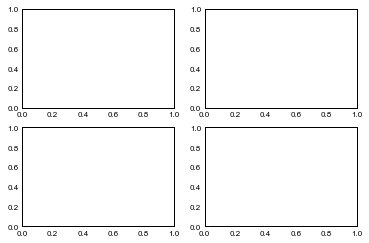

In [6]:
fig, ax = plt.subplots(2,2)
n = neuronList[11]
print(n.index, n.date)
# fig.suptitle("Example cell: {}, {} Different measure showing sublinearity".format(n.index, n.date), fontsize=18)
features = [0,1,2,4]
for index,feature in enumerate(features):
    expected, observed = [], []
    for expType,exp in n:
        if expType == 'Control':
            sqr = 5
            expected, observed = zip(*[(exp[sqr].coordwise[coord].expected_feature[feature],exp[sqr].coordwise[coord].average_feature[feature]) for coord in exp[sqr].coordwise])
    i,j = index/2, index%2
    expected,observed = np.array(expected), np.array(observed)
    subIndices, supraIndices = np.where(np.greater(expected,observed)), np.where(np.less_equal(expected,observed)) 
    ax[i][j].scatter(expected[subIndices], observed[subIndices], label=n.features[feature], s=10, marker='.',color='gray')
    ax[i][j].scatter(expected[supraIndices], observed[supraIndices], label=n.features[feature], s=10, marker='.',color='orange')
    minLim, maxLim = np.min(np.concatenate([expected,observed])), np.max(np.concatenate([expected, observed]))
    ax[i][j].plot((minLim, maxLim), (minLim, maxLim),'--')
    slope, intercept, r2, pval,stderr = ss.linregress(expected, observed)
    expArray = np.linspace(minLim, maxLim,100)
    ax[i][j].plot(expArray, slope*expArray + intercept,'--',c='gray')
    ax[i][j].set_xlim(minLim, maxLim)
    ax[i][j].set_ylim(minLim, maxLim)
    print("Slope = {:.2f}, $r^2={:.2f}$".format(slope, r2), len(observed))
# ax[0][0].set_xlabel("Expected Sum (mV)")
#ax[0][0].set_ylabel("Observed Sum (mV)")
#ax[1][0].set_xlabel("Expected Sum (mV)")
#ax[1][0].set_ylabel("Observed Sum (mV)")

# ax[0][1].set_xlabel("Expected Sum (mV.ms)")
# ax[0][1].set_ylabel("Observed Sum (mV.ms)")
#ax[1][1].set_xlabel("Expected Sum (mV.ms)")
# ax[1][1].set_ylabel("Observed Sum (mV.ms)")

#     ax[i][j].legend(loc='best')
# for axis in ax.flatten():
#     axis.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#     axis.yaxis.major.formatter._useMathText = True
ax[1][1].set_yticks([0.0, 0.1])
simpleaxis(ax)
fig.text(0.5, 0.04, 'Expected sum', ha='center', fontsize=10)
fig.text(0.04, 0.5, 'Observed sum', va='center', rotation='vertical', fontsize=10)
fig.set_figheight(4)
fig.set_figwidth(4)
dump(fig,file('figures/fig3/3e.pkl','wb'))
plt.savefig('figures/fig3/fig3e.svg')
plt.show()

## 3 F: Ratios of O/E mostly sublinear

In [36]:
def figureF(feature = 0, only_plot_square=5,xmax=2.5):
    ''' Plotting to show sublinearity of CA3 inputs at CA1. '''
    ratio = []
    numNeurons = 0
    numBins = 50
    valid_neuron = []
    for neuron in neuronList:
        if (neuron):
            for expType, exp in neuron:
                if expType == "Control":            
                    for numSq in exp:
                        if numSq > 1:
                            if numSq == only_plot_square: # If one vs five required
                                numNeurons+=1
                                coords = exp[numSq].coordwise
                                for coord in coords:
                                    try:
                                        if feature in coords[coord].average_feature and coords[coord].expected_feature:
                                            if not np.isnan(coords[coord].average_feature[feature]/coords[coord].expected_feature[feature]) and not np.isinf(coords[coord].average_feature[feature]/coords[coord].expected_feature[feature]):
                                                ratio.append(coords[coord].average_feature[feature]/coords[coord].expected_feature[feature])
                                                valid_neuron.append(neuron.date + '_' + neuron.index)
                                    except:
                                        print ("Couldn't append to ratio, perhaps feature not found")
    ratio = np.array(ratio)
    gt_one = ratio[np.where(ratio>1)]
    frac_gt_one = round((float(len(gt_one))/len(ratio))*1e2,2)
    #print [x for x in ratio]
    fig, ax = plt.subplots()
    fig.set_figheight(1.5)
    fig.set_figwidth(1.5)
    bins = np.linspace(0,xmax,numBins)
    n, bins, patches = ax.hist(ratio, bins=bins, color='gray')
    print ("Average ratio is {:.2f}, standard deviation is {:.2f}".format(np.average(ratio), np.std(ratio,ddof=1)))
    for i in range(len(patches)):
        if bins[i]>1:
            patches[i].set_facecolor('orange')
    
    ax.set_title("Sublinearity of input summation")
#     ax.axvline(1.0, linestyle='dashed', linewidth=2, color='0.5')
    ax.set_xlabel("O/E")
    ax.set_ylabel("# PSPs")
    ax.set_xlim(0,xmax)
    simpleaxis(ax,outward=False)
    dump(fig,file('figures/fig3/3f_{}.pkl'.format(only_plot_square),'wb'))
#     ax.annotate("{} %".format(frac_gt_one), xy=(1, 800), xytext=(1.5, 800), textcoords='data', arrowprops=dict(connectionstyle="arc3", arrowstyle = "<-"))
    plt.show()
    print ("Legend text: Number of cells: {}, number of points: {}, fraction of points lesser than one: {}".format(len(set(valid_neuron)), len(ratio), 100 - frac_gt_one ))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars


Average ratio is 0.57, standard deviation is 0.31


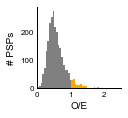

Legend text: Number of cells: 33, number of points: 2513, fraction of points lesser than one: 93.35


In [37]:
figureF()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars


Average ratio is 0.78, standard deviation is 0.56


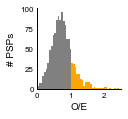

Legend text: Number of cells: 20, number of points: 1284, fraction of points lesser than one: 80.61
Average ratio is 0.58, standard deviation is 0.43


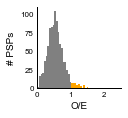

Legend text: Number of cells: 19, number of points: 1011, fraction of points lesser than one: 94.66
Average ratio is 0.47, standard deviation is 0.21


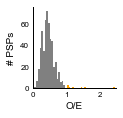

Legend text: Number of cells: 15, number of points: 530, fraction of points lesser than one: 98.49
Average ratio is 0.30, standard deviation is 0.08


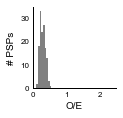

Legend text: Number of cells: 6, number of points: 138, fraction of points lesser than one: 100.0


In [39]:
figureF(only_plot_square=2)
figureF(only_plot_square=3)
figureF(only_plot_square=7)
figureF(only_plot_square=9)

## 3 G: Regression slopes differ between cells

In [19]:
def figureG(feature = 0):
    ''' Plotting to show sublinearity of CA3 inputs at CA1. '''
    numBins = 10
    numSq = 5
    slopes = []
    index = []
    valid_neuron = []
    for neuron in neuronList:
        if (neuron):
            for experiment in neuron.experiment:
                if experiment == "Control":            
                        if numSq in neuron.experiment[experiment]:
                            slope = neuron.experiment[experiment][numSq].regression_coefficients[feature]['slope']
                            if np.isnan(slope):
                                print (neuron.index, neuron.date)
                            if not np.isnan(slope):
                                index.append(neuron.date + '_' + neuron.index)
                                slopes.append(neuron.experiment[experiment][numSq].regression_coefficients[feature]['slope'])
                                valid_neuron.append(neuron.date + '_' + neuron.index)
                        else:
                            print ("Doesn't have {} square input".format(numSq))
#     print (zip(index, slopes))
    fig, ax = plt.subplots()
    fig.set_figheight(1.5)
    fig.set_figwidth(1.5)
    n, bins, patches = ax.hist(slopes,bins=numBins, color='gray')
    print ("Average slope is {:.2f}, standard deviation is {:.2f}".format(np.average(slopes), np.std(slopes,ddof=1)))
    for i in range(len(patches)):
        if bins[i]>1:
            patches[i].set_facecolor('orange')
            
    ax.set_title("Variability of slopes between cells")
#     ax.axvline(1.0, linestyle='dashed', linewidth=2)
    ax.set_xlabel("Slopes")
    ax.set_ylabel("# cells")
    ax.set_xlim(xmin=0.,xmax=1.)
    simpleaxis(ax)
    dump(fig,file('figures/fig3/3g_{}.pkl'.format(feature),'wb'))
    plt.show()
    print("Number of neurons is {}".format(len(set(valid_neuron))))

Doesn't have 5 square input
Doesn't have 5 square input
Doesn't have 5 square input
Doesn't have 5 square input
Doesn't have 5 square input
Average slope is 0.38, standard deviation is 0.22


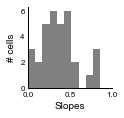

Number of neurons is 33


In [20]:
figureG()

Doesn't have 5 square input
Doesn't have 5 square input
Doesn't have 5 square input
Doesn't have 5 square input
Doesn't have 5 square input
Average slope is 0.27, standard deviation is 0.23


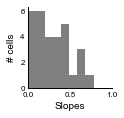

Number of neurons is 33


In [21]:
figureG(feature = 1)

Doesn't have 5 square input
Doesn't have 5 square input
Doesn't have 5 square input
Doesn't have 5 square input
Doesn't have 5 square input
Average slope is 0.26, standard deviation is 0.23


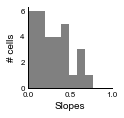

Number of neurons is 33


In [22]:
figureG(feature = 2)

c2 150828
c2 150902
c1 150904
Doesn't have 5 square input
Doesn't have 5 square input
c4 160209
c5 160219
Doesn't have 5 square input
c1 160830
Doesn't have 5 square input
Doesn't have 5 square input
2_c1_150828 Control_RS_short
6_c2_160513 Control_RS_short
Average slope is 0.23, standard deviation is 0.21


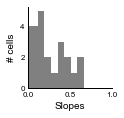

Number of neurons is 25


In [23]:
figureG(feature = 4)